# Milk Sales Demand Forecasting


**1.Executive Summary**

This project develops an end-to-end demand forecasting system for daily milk sales of an FMCG SKU using historical transactional data (2022–2024). The objective is to build accurate short-term forecasts to support inventory planning and promotional decision-making.


Three modeling approaches were evaluated:

**ARIMA** (baseline statistical model)

**SARIMAX** (seasonal model with exogenous variables)

**XGBoost** (machine learning with lag and rolling features)

Model performance was evaluated using MAE, RMSE, and MAPE metrics, along with expanding window (rolling) validation to test temporal stability.

Key findings:

XGBoost achieved the lowest MAPE (~10-11% %) compared to SARIMAX model (13-15%)

Weekly sales momentum (rolling mean) is the strongest demand driver.

Promotional activity creates measurable uplift in demand.

Stock levels influence predictions but primarily act as a supply buffer.

Business simulation shows that full-month promotion increases total monthly sales significantly, but selective promotional days may be more cost-effective.

The final recommended model for operational forecasting is **XGBoost**, due to superior accuracy and stability.

**2.Problem Statement**

Milk is a perishable FMCG product requiring precise demand forecasting to avoid:

    1. Stockouts (lost sales)

    2. Overstocking (wastage)

    3. Inefficient promotional planning

The goal of this project is to:

Forecast daily milk sales for a specific SKU-MI-006 using historical demand data and business drivers (promotion, stock, price, delivery).

The forecasting system should:

    1. Capture weekly seasonality if any

    2. Incorporate business variables

    3. Provide reliable short-term forecasts (e.g., January 2025)

    4. Quantify uncertainty using confidence intervals

    5. Support promotional scenario analysis

**3. Dataset Description**

The dataset contains daily sales data from January 2022 to December 2024.

1. Date - Daily timestamp
2. Units sold- Number of units sold (target variable)
3. Promo- Promotion flag (1 = promotion active, 0 = no promotion)
4. Stock- Available Inventory
5. Price - Average price taken on mix of carton, multipack, and Single pack
6. Delivery days - Days for delivery

**4.Data loading & Exploratory Data Analysis (EDA)**

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [7]:
df=pd.read_excel('Milk - Copy.xlsx')
df

,date,sku,category,price_unit,promotion_flag,delivery_days,stock_available,delivered_qty,units_sold
0,2022-01-21,MI-006,Milk,2.38,0,1,141,128,9
1,2022-01-21,MI-006,Milk,1.55,1,3,0,129,0
2,2022-01-21,MI-006,Milk,4.00,0,5,118,161,8
3,2022-01-21,MI-006,Milk,5.16,0,2,81,114,7
4,2022-01-21,MI-006,Milk,7.66,0,4,148,204,12
...,...,...,...,...,...,...,...,...,...
8216,2024-12-31,MI-006,Milk,1.86,1,4,203,245,27
8217,2024-12-31,MI-006,Milk,2.52,0,5,117,172,13
8218,2024-12-31,MI-006,Milk,1.80,0,5,153,186,11
8219,2024-12-31,MI-006,Milk,6.20,0,3,112,151,9


In [8]:
df=df.drop(['sku','category', 'delivered_qty'],axis=1)

In [9]:
df.head()

,date,price_unit,promotion_flag,delivery_days,stock_available,units_sold
0,2022-01-21,2.38,0,1,141,9
1,2022-01-21,1.55,1,3,0,0
2,2022-01-21,4.00,0,5,118,8
3,2022-01-21,5.16,0,2,81,7
4,2022-01-21,7.66,0,4,148,12


In [10]:
units_daily=df.groupby('date')['units_sold'].sum()
units_daily.name='units_sold'
units_daily

date
2022-01-21     85
2022-01-22    119
2022-01-23    122
2022-01-24     76
2022-01-25     76
             ... 
2024-12-27    114
2024-12-28    103
2024-12-29    124
2024-12-30     90
2024-12-31     79
Name: units_sold, Length: 1076, dtype: int64

In [12]:
promo_daily=df.groupby('date')['promotion_flag'].max()
promo_daily.name='promo'
promo_daily

date
2022-01-21    1
2022-01-22    1
2022-01-23    1
2022-01-24    0
2022-01-25    0
             ..
2024-12-27    1
2024-12-28    1
2024-12-29    1
2024-12-30    0
2024-12-31    1
Name: promo, Length: 1076, dtype: int64

In [14]:
stock_daily=df.groupby('date')['stock_available'].sum()
stock_daily.name= 'stock'
stock_daily


date
2022-01-21     985
2022-01-22    1390
2022-01-23    1446
2022-01-24    1140
2022-01-25    1077
              ... 
2024-12-27    1365
2024-12-28    1005
2024-12-29    1481
2024-12-30    1406
2024-12-31     847
Name: stock, Length: 1076, dtype: int64

In [20]:
deliv_daily=df.groupby('date')['delivery_days'].mean()
deliv_daily.name='delivery_days'

In [21]:
df['total price']=df['price_unit']*df['units_sold']

In [22]:
price_daily=df.groupby('date')['total price'].sum()/ df.groupby('date')['units_sold'].sum()

In [23]:
price_daily.head()
price_daily.name='price'

In [24]:
df_final_1=pd.concat([units_daily,promo_daily,stock_daily,deliv_daily,price_daily],axis=1)
df_final_1

,units_sold,promotion_flag,stock,delivery_days,price
date,,,,,
2022-01-21,85,1,985,2.875000,5.180471
2022-01-22,119,1,1390,3.428571,4.618067
2022-01-23,122,1,1446,3.750000,5.752787
2022-01-24,76,0,1140,2.250000,5.636974
2022-01-25,76,0,1077,3.285714,5.272500
...,...,...,...,...,...
2024-12-27,114,1,1365,3.571429,7.107193
2024-12-28,103,1,1005,3.428571,5.328544
2024-12-29,124,1,1481,3.000000,4.960081


In [25]:
df_final_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1076 entries, 2022-01-21 to 2024-12-31
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   units_sold      1076 non-null   int64  
 1   promotion_flag  1076 non-null   int64  
 2   stock           1076 non-null   int64  
 3   delivery_days   1076 non-null   float64
 4   price           1076 non-null   float64
dtypes: float64(2), int64(3)
memory usage: 50.4 KB


In [26]:
df_final_1.duplicated().sum()

0

In [27]:
df_final_1.index=pd.to_datetime(df_final_1.index)
df_final_2=df_final_1.sort_index()

In [28]:
df_final_2.head()

,units_sold,promotion_flag,stock,delivery_days,price
date,,,,,
2022-01-21,85,1,985,2.875000,5.180471
2022-01-22,119,1,1390,3.428571,4.618067
2022-01-23,122,1,1446,3.750000,5.752787
2022-01-24,76,0,1140,2.250000,5.636974
2022-01-25,76,0,1077,3.285714,5.272500


In [30]:
df_final_2.describe()

,units_sold,promotion_flag,stock,delivery_days,price
count,1076.000000,1076.000000,1076.000000,1076.000000,1076.000000
mean,123.255576,0.709108,1207.564126,2.995633,5.217746
std,39.074987,0.454385,213.322088,0.509370,0.865756
min,31.000000,0.000000,318.000000,1.400000,2.565600
25%,97.000000,0.000000,1066.000000,2.666667,4.608785
50%,118.000000,1.000000,1208.000000,3.000000,5.223785
75%,140.250000,1.000000,1356.000000,3.333333,5.787259
max,317.000000,1.000000,1819.000000,4.714286,7.599111


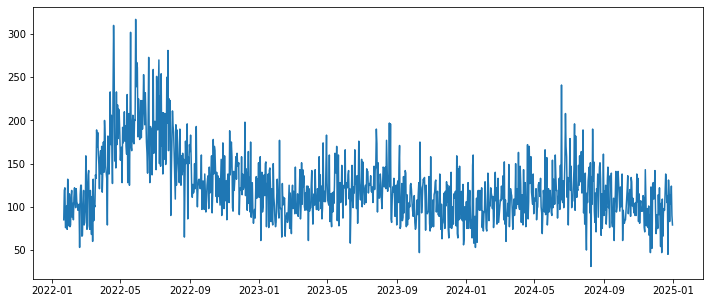

In [31]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))
plt.plot(df_final_2['units_sold'])
plt.show()

In [32]:
import seaborn as sns

C:\Users\mohit\anaconda3a\lib\site-packages\scipy\__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


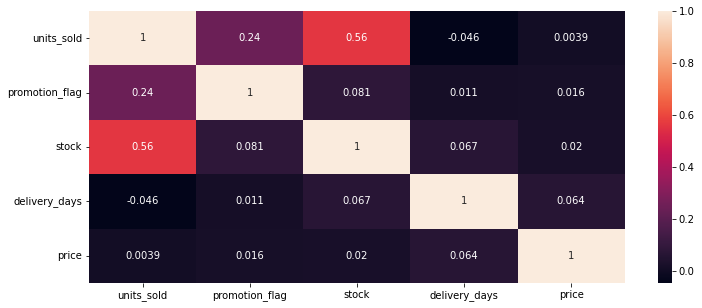

In [33]:
plt.figure(figsize=(12,5))
sns.heatmap(df_final_2.corr(),annot=True)
plt.show()

**Check whether data is statinary**

In [34]:
from statsmodels.tsa.stattools import adfuller

adfuller(df_final_2['units_sold'])

(-2.075145204128275,
 0.2546255530979142,
 16,
 1059,
 {'1%': -3.436540010983293,
  '5%': -2.8642730819775406,
  '10%': -2.5682251959417948},
 10090.656132152992)

In [36]:
result=adfuller(df_final_2['units_sold'])
print('ADF Statistic',result[0])
print('p_value',result[1])

ADF Statistic -2.075145204128275
p_value 0.2546255530979142


In [37]:
#As p value is >0.05, we fail to reject null hypothesis & conclude that series is non stationary.

In [38]:
# calculating rolling mean of 30 days for visual stationary check

In [39]:
rolling_mean=df_final_2['units_sold'].rolling(30).mean()
rolling_std=df_final_2['units_sold'].rolling(30).std()

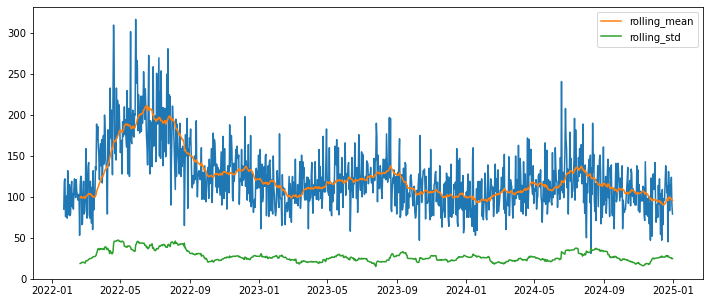

In [40]:
plt.figure(figsize=(12,5))
plt.plot(df_final_2['units_sold'])
plt.plot(rolling_mean,label='rolling_mean')
plt.plot(rolling_std,label='rolling_std')
plt.legend()
plt.show()

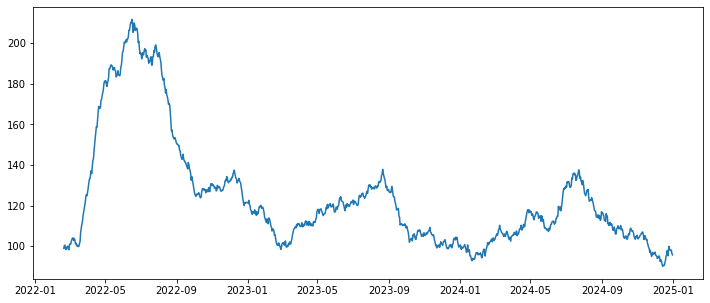

In [41]:
plt.figure(figsize=(12,5))

plt.plot(rolling_mean,label='rolling_mean')

plt.show()

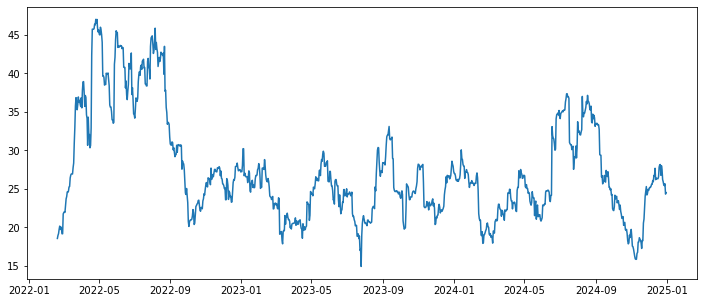

In [43]:
plt.figure(figsize=(12,5))
plt.plot(rolling_std,label='rolling_std')
plt.show()

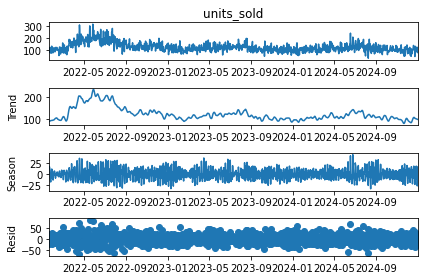

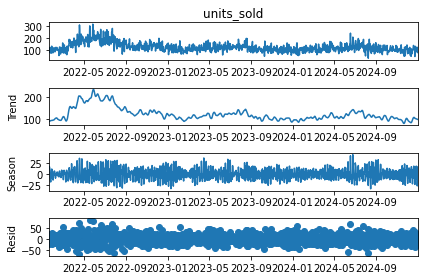

In [44]:
from statsmodels.tsa.seasonal import STL
stl=STL(df_final_2['units_sold'],period=7)
res=stl.fit()
res.plot()

To determine whether the time series is stationary, the Augmented Dickey-Fuller (ADF) test was performed.

ADF Statistic: -2.075

**p-value: 0.254**

Since the p-value is greater than 0.05, we fail to reject the null hypothesis, indicating that the sales time series is **non-stationary**.

Additionally, a 30-day rolling mean and rolling standard deviation were plotted to visually inspect stationarity.

Visual Interpretation:

The rolling mean shows noticeable shifts over time.

The rolling standard deviation is not constant across the entire period.

Demand spikes are observed during certain periods, likely due to promotional campaigns or seasonal effects.

**Conclusion**:

The series exhibits non-stationary behavior in both mean and variance.
Therefore, differencing is required before applying ARIMA or SARIMA -based models.

In [46]:
#From the above Trend graph we can clearly conclude that Series has trend. Now lets check for Seasonality

In [47]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(
    df_final_2['units_sold'],
    model='additive',
    period=7
)

In [49]:
trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid


In [52]:
residual = residual.dropna()
seasonal = seasonal.dropna()

seasonal_strength = 1 - (np.var(residual) / np.var(seasonal + residual))

print("Seasonal Strength:", seasonal_strength)


Seasonal Strength: 0.003313577766377973


In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition_1 = seasonal_decompose(
    df_final_2['units_sold'],
    model='additive',
    period=30
)

In [56]:
trend_1= decomposition_1.trend
seasonal_1 = decomposition_1.seasonal
residual_1= decomposition_1.resid


In [57]:
residual_1 = residual_1.dropna()
seasonal_1 = seasonal_1.dropna()

seasonal_strength_1 = 1 - (np.var(residual_1) / np.var(seasonal_1 + residual_1))

print("Seasonal Strength:", seasonal_strength_1)


Seasonal Strength: 0.027351618879302375


**As weekly seasonal strength is 0.003 & monthly season strength os 0.027 whcih is clsoe to 0 so we can conclude that the 
series has no seasonality**

In [60]:
trend = trend.dropna()

trend_strength = 1 - (np.var(residual.dropna()) /  np.var((trend + residual).dropna()))

print("Trend Strength:", trend_strength)


Trend Strength: 0.5850085568254961


In [61]:
from scipy.stats import linregress

y = df_final_2['units_sold'].values
x = np.arange(len(y))

slope, intercept, r_value, p_value, std_err = linregress(x, y)

print("Slope:", slope)
print("p-value:", p_value)


Slope: -0.05063397384693223
p-value: 3.295517954983803e-43


**As trend strength is 0.58 & its p value ia <0.05, so we can conclude that the series has trend.**

<Figure size 864x360 with 0 Axes>

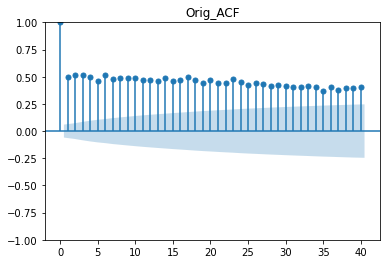

C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x360 with 0 Axes>

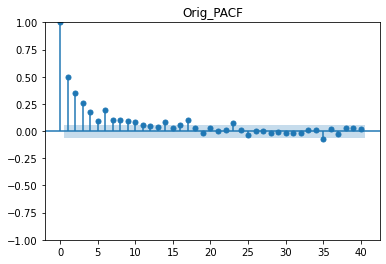

In [62]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plt.figure(figsize=(12,5))
plot_acf(df_final_2['units_sold'],lags=40)
plt.title('Orig_ACF')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df_final_2['units_sold'],lags=40)
plt.title('Orig_PACF')
plt.show()

**Slow decaying ACF shows non stationary series**

In [63]:
df_diff=df_final_2['units_sold'].diff().dropna()
df_diff

date
2022-01-22    34.0
2022-01-23     3.0
2022-01-24   -46.0
2022-01-25     0.0
2022-01-26    25.0
              ... 
2024-12-27    31.0
2024-12-28   -11.0
2024-12-29    21.0
2024-12-30   -34.0
2024-12-31   -11.0
Name: units_sold, Length: 1075, dtype: float64

In [64]:
from statsmodels.tsa.stattools import adfuller
result=adfuller(df_diff)

print("ADF Statistic:", result[0])
print("p-value:", result[1])

ADF Statistic: -13.818627613689786
p-value: 7.98177095099336e-26


**As value of p<0.05 , we confirm that on differencing the series became stationary & we can use ARIMA with d=1 as one of teh assumption is seris should be stationary . We are not using SARIMA as seris do not have seasnonal effect.**

**Plotting ACF & PACF post differencing**

<Figure size 864x360 with 0 Axes>

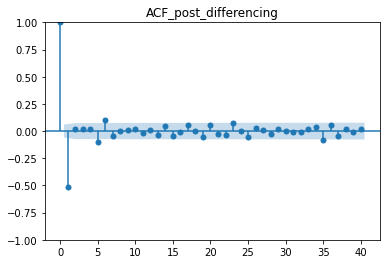

C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


<Figure size 864x360 with 0 Axes>

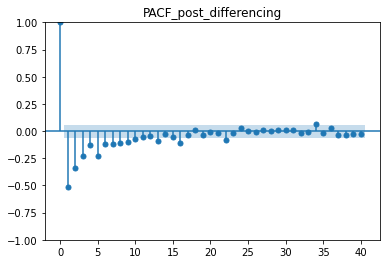

In [66]:
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
plt.figure(figsize=(12,5))
plot_acf(df_diff,lags=40)
plt.title('ACF_post_differencing')
plt.show()

plt.figure(figsize=(12,5))
plot_pacf(df_diff,lags=40)
plt.title('PACF_post_differencing')
plt.show()

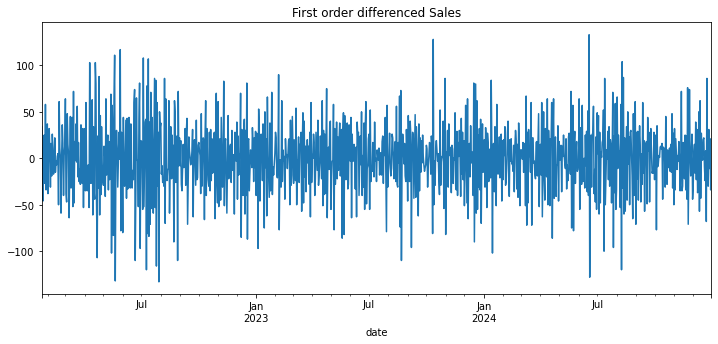

In [70]:
df_diff.plot(figsize=(12,5))
plt.title('First order differenced Sales')
plt.show()


After first-order differencing, the series became stationary (ADF p-value < 0.05).
ACF and PACF plots were analyzed to determine AR and MA components.

Observations:
**ACF shows a significant spike at lag 1 and cuts off afterwards, indicating an MA(1) process. 
PACF shows gradual decay without clear cutoff, suggesting absence of strong AR component
AR → depends on past values,  
MA → depends on past shocks,   
ACF → detects MA (q value),   
PACF → detects AR (p value)**

Therefore **ARIMA(0,1,1)** model is selected.

In [71]:
from statsmodels.tsa.arima.model import ARIMA

model_011 = ARIMA(df_final_2['units_sold'], order=(0,1,1)).fit()
model_110 = ARIMA(df_final_2['units_sold'], order=(1,1,0)).fit()
model_111 = ARIMA(df_final_2['units_sold'], order=(1,1,1)).fit()

print("AIC (0,1,1):", model_011.aic)
print("AIC (1,1,0):", model_110.aic)
print("AIC (1,1,1):", model_111.aic)


C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


AIC (0,1,1): 10281.640228638018
AIC (1,1,0): 10608.297880522498
AIC (1,1,1): 10283.118348128173


C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  

From abaove we can see that AIC(0,1,1) is lowest so choosing ARIMA(0,1,1)

**5. Baseline Model — ARIMA (0,1,1)**

In [75]:
split=int(len(df_final_2)*0.8)
train= df_final_2['units_sold'][:split]
test= df_final_2['units_sold'][split:]

In [77]:
train

date
2022-01-21     85
2022-01-22    119
2022-01-23    122
2022-01-24     76
2022-01-25     76
             ... 
2024-05-25     92
2024-05-26    121
2024-05-27     94
2024-05-28    101
2024-05-29    119
Name: units_sold, Length: 860, dtype: int64

In [78]:
test

date
2024-05-30    105
2024-05-31     93
2024-06-01     90
2024-06-02    154
2024-06-03     99
             ... 
2024-12-27    114
2024-12-28    103
2024-12-29    124
2024-12-30     90
2024-12-31     79
Name: units_sold, Length: 216, dtype: int64

In [92]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model_1=SARIMAX(train, order=(0,1,1),seasonal_order=(0,0,0,0))

model_1_fit=model_1.fit()

C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [93]:
forcast_arima=model_1_fit.forecast(steps=len(test))
forcast_arima

2024-05-30    108.631536
2024-05-31    108.631536
2024-06-01    108.631536
2024-06-02    108.631536
2024-06-03    108.631536
                 ...    
2024-12-27    108.631536
2024-12-28    108.631536
2024-12-29    108.631536
2024-12-30    108.631536
2024-12-31    108.631536
Freq: D, Name: predicted_mean, Length: 216, dtype: float64

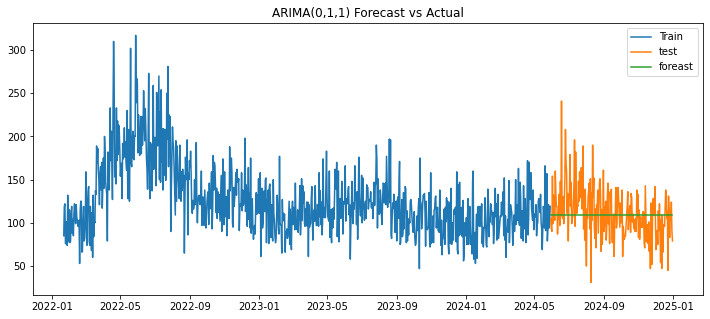

In [94]:
plt.figure(figsize=(12,5))
plt.plot(train.index,train,label='Train')
plt.plot(test.index,test,label='test')
plt.plot(test.index,forcast_arima,label='foreast')
plt.title("ARIMA(0,1,1) Forecast vs Actual")
plt.legend()
plt.show()

In [95]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

mae= mean_absolute_error(test,forcast_arima)
rmse= np.sqrt(mean_squared_error(test,forcast_arima))
MAPE= mean_absolute_percentage_error(test,forcast_arima)*100

print('MAE',mae)
print('RMSE',rmse)
print('MAPE',MAPE)

MAE 22.90375362255434
RMSE 30.26514171448432
MAPE 23.248600513489123


In [96]:
print(model_1_fit.summary())

                               SARIMAX Results                                
Dep. Variable:             units_sold   No. Observations:                  860
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -4107.896
Date:                Sun, 15 Feb 2026   AIC                           8219.792
Time:                        20:47:46   BIC                           8229.304
Sample:                    01-21-2022   HQIC                          8223.434
                         - 05-29-2024                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.8911      0.013    -67.806      0.000      -0.917      -0.865
sigma2       832.6676     31.199     26.689      0.000     771.519     893.816
Ljung-Box (L1) (Q):                   0.29   Jarque-

ARIMA is a univariate time-series model that forecasts future values using only past observations of the target variable (units_sold).However, from exploratory data analysis and feature importance analysis, it is evident that sales are influenced by multiple external factors such as:
Promotions
Stock availability
Delivery days
Price changes
Since ARIMA does not incorporate external regressors, it may fail to capture the true drivers of demand variation.Therefore, a multivariate time-series model such as SARIMAX is more appropriate.

**6.SARIMAX (0,1,1) (0,0,0,0)**

In [99]:
y_train=df_final_2['units_sold'][:split]
y_test=df_final_2['units_sold'][split:]


X_train = df_final_2.iloc[:,1:][:split]
X_test  = df_final_2.iloc[:,1:][split:]


In [101]:
model_sarimax=SARIMAX(y_train, order=(0,1,1), seasonal_order=(0,0,0,0),exog=X_train)

model_sarimax_fit=model_sarimax.fit()

print(model_sarimax_fit.summary())

C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:             units_sold   No. Observations:                  860
Model:               SARIMAX(0, 1, 1)   Log Likelihood               -3668.734
Date:                Sun, 15 Feb 2026   AIC                           7349.468
Time:                        20:50:00   BIC                           7378.003
Sample:                    01-21-2022   HQIC                          7360.393
                         - 05-29-2024                                         
Covariance Type:                  opg                                         
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
promotion_flag    19.9103      1.460     13.634      0.000      17.048      22.772
stock              0.0953      0.003     33.823      0.000       0.090       0.101
delivery_days     -1.0151      1.129

In [102]:
forcast_sarimax=model_sarimax_fit.forecast(steps=len(y_test), exog=X_test)
forcast_sarimax

2024-05-30    110.187397
2024-05-31    107.562132
2024-06-01     83.689467
2024-06-02    145.342516
2024-06-03    108.362110
                 ...    
2024-12-27    136.705864
2024-12-28    102.173040
2024-12-29    147.919444
2024-12-30    120.278396
2024-12-31     86.148907
Freq: D, Name: predicted_mean, Length: 216, dtype: float64

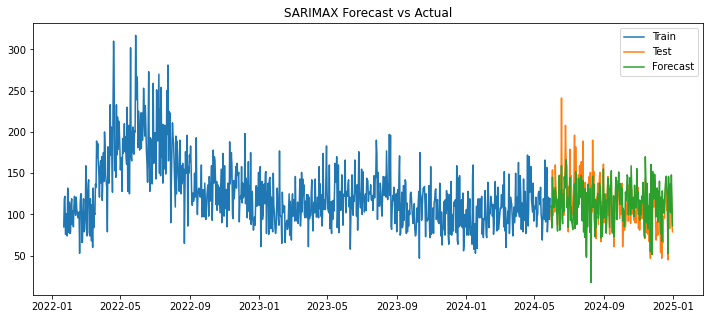

In [103]:
plt.figure(figsize=(12,5))
plt.plot(y_train.index, y_train, label='Train')
plt.plot(y_test.index, y_test, label='Test')
plt.plot(y_test.index, forcast_sarimax, label='Forecast')
plt.title('SARIMAX Forecast vs Actual')
plt.legend()
plt.show()


In [105]:
mae_1= mean_absolute_error(y_test,forcast_sarimax)
rmse_1= np.sqrt(mean_squared_error(y_test,forcast_sarimax))
MAPE_1= mean_absolute_percentage_error(y_test,forcast_sarimax)*100

print('MAE_1',mae_1)
print('RMSE_1',rmse_1)
print('MAPE_1',MAPE_1)

MAE_1 15.052475082482939
RMSE_1 19.13386578878485
MAPE_1 14.061752066231255


The SARIMAX(0,1,1) model was estimated using promotion activity, stock availability, delivery lead time, and price as exogenous variables.

Key Findings:

Promotion Effect- Coefficient: 19.91

P-value: < 0.001

Promotion increases daily sales by approximately 20 units on average, indicating strong promotional elasticity.

Stock Availability- Coefficient: 0.095

P-value: < 0.001- Higher stock levels positively influence sales, confirming availability-driven demand.

Delivery Days- Not statistically significant.

Suggests delivery lead time does not directly influence daily demand in this dataset.

Price- Not statistically significant.

Indicates milk demand in this dataset may be relatively price inelastic.

**Residual Diagnostics:**
Ljung-Box test indicates no remaining autocorrelation. Model adequately captures time dependency.

The inclusion of exogenous variables improved forecasting accuracy by approximately 39% relative to the univariate ARIMA model.

**(23% → 14% is a major improvement)**

**Training Sarimax model on entire datasets to forecast Jan 2025 sales**

In [119]:
df_future_1=pd.read_excel(r"C:\Users\mohit\OneDrive\Desktop\Book1_tim.xlsx")
df_future_1.head()

,date,promotion_flag,stock,delivery_days,price
0,2025-01-01,1,900,2,4.053191
1,2025-01-02,0,950,3,4.924404
2,2025-01-03,1,1000,2,6.225606
3,2025-01-04,1,980,3,4.606989
4,2025-01-05,1,990,3,5.331429


In [120]:
df_future_1['date']=pd.to_datetime(df_future_1['date'])
df_future_1.set_index('date',inplace=True)
df_future_1=df_future_1.sort_index()
df_future_1.head()

,promotion_flag,stock,delivery_days,price
date,,,,
2025-01-01,1,900,2,4.053191
2025-01-02,0,950,3,4.924404
2025-01-03,1,1000,2,6.225606
2025-01-04,1,980,3,4.606989
2025-01-05,1,990,3,5.331429


In [121]:
future_exog=df_future_1[['promotion_flag','stock','delivery_days','price']]

In [122]:
model_sarimax_all=SARIMAX(df_final_2['units_sold'], exog=df_final_2[['promotion_flag','stock','delivery_days','price']],order=(0,1,1),seasonal_order=(0,0,0,0))

model_sarimax_all_fit=model_sarimax_all.fit()

C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)
C:\Users\mohit\anaconda3a\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  self._init_dates(dates, freq)


In [123]:
forcast_31_sarimax=model_sarimax_all_fit.forecast(steps=31,exog=future_exog)

forcast_31_sarimax

2025-01-01     78.061648
2025-01-02     62.040058
2025-01-03     87.908134
2025-01-04     84.069218
2025-01-05     85.130096
2025-01-06     69.783301
2025-01-07     85.944981
2025-01-08     96.965102
2025-01-09     77.915024
2025-01-10    104.845324
2025-01-11     68.722798
2025-01-12     77.952790
2025-01-13     81.352748
2025-01-14     35.040813
2025-01-15     76.500935
2025-01-16     86.216483
2025-01-17     63.156698
2025-01-18     65.909226
2025-01-19     87.446581
2025-01-20    116.377487
2025-01-21     95.454349
2025-01-22     92.375901
2025-01-23     66.946278
2025-01-24     78.242784
2025-01-25     90.541118
2025-01-26     85.931844
2025-01-27     60.217470
2025-01-28    114.399981
2025-01-29    145.028049
2025-01-30    154.304767
2025-01-31    128.741133
Freq: D, Name: predicted_mean, dtype: float64

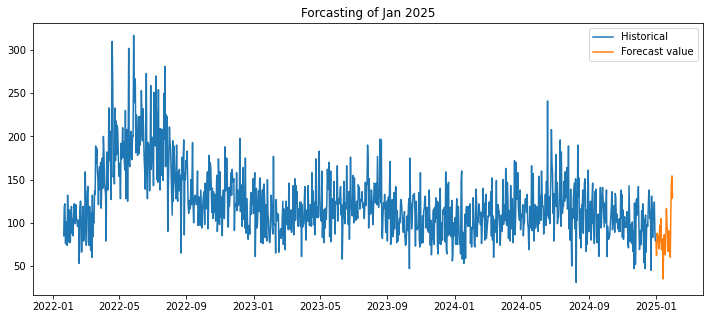

In [124]:
plt.figure(figsize=(12,5))
plt.plot(df_final_2.index,df_final_2['units_sold'],label='Historical')
plt.plot(forcast_31_sarimax.index,forcast_31_sarimax,label='Forecast value')
plt.title('Forcasting of Jan 2025')
plt.legend()
plt.show()

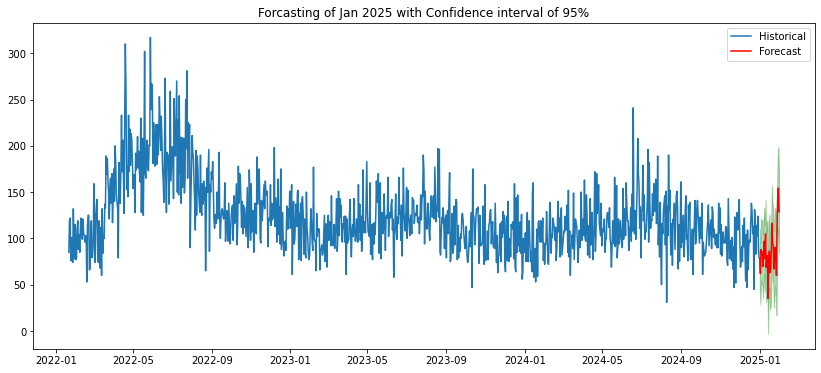

In [127]:
forecast_obj = model_sarimax_all_fit.get_forecast(
                    steps=31,
                    exog=future_exog
                )

forecast_mean = forecast_obj.predicted_mean
forecast_ci = forecast_obj.conf_int()

plt.figure(figsize=(14,6))
plt.plot(df_final_2.index, df_final_2['units_sold'], label='Historical')
plt.plot(forecast_mean.index, forecast_mean, color='red', label='Forecast')

plt.fill_between(
    forecast_ci.index,
    forecast_ci.iloc[:,0],
    forecast_ci.iloc[:,1],
    color='green',
    alpha=0.3
)

plt.title('Forcasting of Jan 2025 with Confidence interval of 95%')
plt.legend()
plt.show()

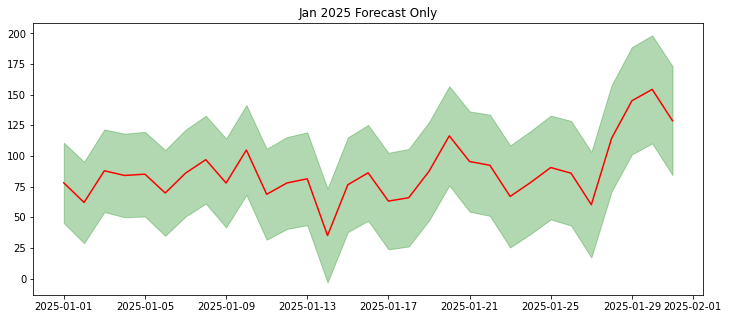

In [128]:
plt.figure(figsize=(12,5))

plt.plot(forecast_mean.index, forecast_mean, color='red')
plt.fill_between(forecast_ci.index,
                 forecast_ci.iloc[:,0],
                 forecast_ci.iloc[:,1],
                 color='green', alpha=0.3)

plt.title("Jan 2025 Forecast Only")
plt.show()


In [129]:
print(forecast_mean)
print("*"*30)
print(forecast_ci)


2025-01-01     78.061648
2025-01-02     62.040058
2025-01-03     87.908134
2025-01-04     84.069218
2025-01-05     85.130096
2025-01-06     69.783301
2025-01-07     85.944981
2025-01-08     96.965102
2025-01-09     77.915024
2025-01-10    104.845324
2025-01-11     68.722798
2025-01-12     77.952790
2025-01-13     81.352748
2025-01-14     35.040813
2025-01-15     76.500935
2025-01-16     86.216483
2025-01-17     63.156698
2025-01-18     65.909226
2025-01-19     87.446581
2025-01-20    116.377487
2025-01-21     95.454349
2025-01-22     92.375901
2025-01-23     66.946278
2025-01-24     78.242784
2025-01-25     90.541118
2025-01-26     85.931844
2025-01-27     60.217470
2025-01-28    114.399981
2025-01-29    145.028049
2025-01-30    154.304767
2025-01-31    128.741133
Freq: D, Name: predicted_mean, dtype: float64
******************************
            lower units_sold  upper units_sold
2025-01-01         45.295569        110.827727
2025-01-02         28.820169         95.259948
2025-01

Final Forecast – January 2025

The model was retrained on the full dataset (Jan 2022 – Dec 2024) and forecasted January 2025 demand with 95% confidence intervals.

The forecast provides:

Expected daily demand with Upper and lower uncertainty bounds

Would help in Decision support for production and inventory planning



Although SARIMAX incorporates external variables, it assumes:

Linear relationships

Fixed parameter structure

Statistical distribution assumptions

However, retail demand is often:

**Non-linear**

Interaction-driven (promotion × stock × price)

Sensitive to short-term fluctuations

Therefore, we move to a machine learning approach.

**7.ML Model - XG BOOST**

XGBoost was selected because:

It captures non-linear relationships, Handles feature interactions automatically, and Works well with tabular structured data.

Is widely used in retail demand forecasting

Unlike SARIMAX, XGBoost:

Does not assume linearity, Learns complex decision boundaries & Can better model sudden spikes due to promotions

In [131]:
df_final_2.head()

,units_sold,promotion_flag,stock,delivery_days,price
date,,,,,
2022-01-21,85,1,985,2.875000,5.180471
2022-01-22,119,1,1390,3.428571,4.618067
2022-01-23,122,1,1446,3.750000,5.752787
2022-01-24,76,0,1140,2.250000,5.636974
2022-01-25,76,0,1077,3.285714,5.272500


In [132]:
df_ml=df_final_2.copy()
df_ml.head()

,units_sold,promotion_flag,stock,delivery_days,price
date,,,,,
2022-01-21,85,1,985,2.875000,5.180471
2022-01-22,119,1,1390,3.428571,4.618067
2022-01-23,122,1,1446,3.750000,5.752787
2022-01-24,76,0,1140,2.250000,5.636974
2022-01-25,76,0,1077,3.285714,5.272500


In [133]:
df_ml['lag_1']=df_ml['units_sold'].shift(1)
df_ml['lag_7']=df_ml['units_sold'].shift(7)
df_ml['lag_14']=df_ml['units_sold'].shift(14)

df_ml['rol_mean_7']=df_ml['units_sold'].rolling(7).mean()
df_ml['rol_std_7']=df_ml['units_sold'].rolling(7).std()

In [134]:
df_ml.head(10)

,units_sold,promotion_flag,stock,delivery_days,price,lag_1,lag_7,lag_14,rol_mean_7,rol_std_7
date,,,,,,,,,,
2022-01-21,85,1,985,2.875000,5.180471,NaN,NaN,NaN,NaN,NaN
2022-01-22,119,1,1390,3.428571,4.618067,85.0,NaN,NaN,NaN,NaN
2022-01-23,122,1,1446,3.750000,5.752787,119.0,NaN,NaN,NaN,NaN
2022-01-24,76,0,1140,2.250000,5.636974,122.0,NaN,NaN,NaN,NaN
2022-01-25,76,0,1077,3.285714,5.272500,76.0,NaN,NaN,NaN,NaN
2022-01-26,101,1,1170,3.428571,3.975149,76.0,NaN,NaN,NaN,NaN
2022-01-27,74,0,992,3.000000,4.509459,101.0,NaN,NaN,93.285714,20.750215
2022-01-28,132,1,1523,3.111111,5.314545,74.0,85.0,NaN,100.000000,24.826062
2022-01-29,98,1,1337,2.125000,4.281633,132.0,119.0,NaN,97.000000,23.373774


In [135]:
df_ml=df_ml.dropna()
df_ml.head()

,units_sold,promotion_flag,stock,delivery_days,price,lag_1,lag_7,lag_14,rol_mean_7,rol_std_7
date,,,,,,,,,,
2022-02-04,119,0,1448,4.000000,5.595462,111.0,132.0,85.0,96.714286,18.661139
2022-02-05,88,1,1133,3.000000,6.018182,119.0,98.0,119.0,95.285714,18.927179
2022-02-06,104,1,1056,3.571429,6.351058,88.0,78.0,122.0,99.000000,17.464249
2022-02-07,85,0,1149,3.875000,5.763647,104.0,115.0,76.0,94.714286,16.539995
2022-02-08,111,1,1123,2.714286,4.698378,85.0,77.0,76.0,99.571429,15.425705


In [136]:
X=df_ml.iloc[:,1:]
y=df_ml['units_sold']

In [137]:
split=int(len(df_ml)*0.8)

X_train_ml= X[0:split]
X_test_ml= X[split:]

y_train_ml=y[0:split]
y_test_ml=y[split:]

In [138]:
from xgboost import XGBRegressor
model_xgb=XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=4,random_state=42)

In [139]:
model_xgb.fit(X_train_ml,y_train_ml)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [140]:
y_pred_ml=model_xgb.predict(X_test_ml)
y_pred_ml

array([127.77911 , 106.00632 , 126.71788 , 100.0051  , 107.45775 ,
       143.01208 , 133.94348 , 127.06499 , 106.21774 ,  90.2004  ,
       117.733025, 107.91815 , 139.01015 ,  84.52522 , 118.690674,
       105.46995 , 172.13351 , 107.146805, 102.95002 , 140.8726  ,
       105.57669 , 167.77007 , 153.50465 , 161.52538 , 168.50586 ,
       186.99347 , 158.28801 , 158.45044 ,  94.34234 , 126.15296 ,
       143.62381 , 154.73349 , 100.43345 , 124.66738 , 103.56657 ,
       100.88638 ,  86.52517 , 111.495026, 132.49348 , 146.7974  ,
        78.3908  , 174.36147 , 181.19655 , 109.01029 , 127.28277 ,
       135.27512 , 152.48076 , 116.1593  , 148.91025 , 135.42236 ,
       140.43852 , 164.1639  , 118.58169 , 115.5377  , 167.01631 ,
        99.06974 , 111.65974 ,  82.955765, 145.36664 ,  82.254555,
        71.75261 , 110.44888 ,  80.22528 , 130.9338  , 113.27105 ,
       114.00744 ,  77.400505, 135.76233 ,  69.94737 , 112.36006 ,
       100.96724 , 162.9527  , 109.01707 , 152.10835 , 112.150

In [142]:
mae_ml=mean_absolute_error(y_test_ml,y_pred_ml)
mse_ml=mean_squared_error(y_test_ml,y_pred_ml)
rmse_ml=np.sqrt(mse_ml)
map_ml=mean_absolute_percentage_error(y_test_ml,y_pred_ml)*100

print('MAE_ML',mae_ml)
print('MSE_ML',mse_ml)
print('RMSE_ML',rmse_ml)
print('MAP_ML',map_ml)


MAE_ML 11.811564467882327
MSE_ML 250.8152209980199
RMSE_ML 15.837146870507324
MAP_ML 11.365463110104557


<Figure size 864x360 with 0 Axes>

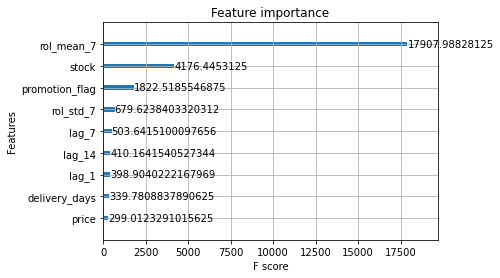

In [143]:
from xgboost import plot_importance
plt.figure(figsize=(12,5))
plot_importance(model_xgb, importance_type='gain')
plt.show()

In [144]:
imp_feat=model_xgb.feature_importances_
features=X_train_ml.columns

pd.DataFrame({'Features':features,'imp_feat':imp_feat}
).sort_values(by='imp_feat',ascending=False)

,Features,imp_feat
7,rol_mean_7,0.674804
1,stock,0.157376
0,promotion_flag,0.068676
8,rol_std_7,0.025609
5,lag_7,0.018978
6,lag_14,0.015456
4,lag_1,0.015031
2,delivery_days,0.012804
3,price,0.011267


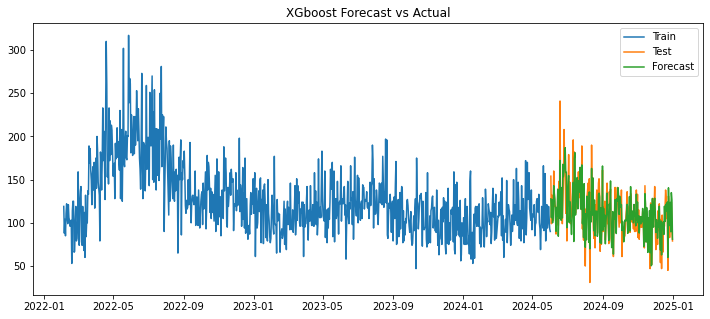

In [148]:
plt.figure(figsize=(12,5))
plt.plot(y_train_ml.index, y_train_ml, label='Train')
plt.plot(y_test_ml.index, y_test_ml, label='Test')
plt.plot(y_test_ml.index, y_pred_ml, label='Forecast')
plt.title('XGboost Forecast vs Actual')
plt.legend()
plt.show()

| Model   | MAE       | RMSE      | MAPE       |
| ------- | --------- | --------- | ---------- |
| ARIMA   | 22.90     | 30.26     | 23.24%     |
| SARIMAX | 15.05     | 19.13     | 14.06%     |
| XGBoost | **11.81** | **15.83** | **11.36%** |


XGBoost outperforms both ARIMA and SARIMAX across all evaluation metrics.

This indicates:

Sales demand is not purely linear.

Non-linear interactions between promotion, stock, and lag variables significantly influence demand.

Machine learning captures short-term fluctuations better than statistical models.


**Features**

1. Rolling Mean (7 days) – Highest Impact

Recent weekly average demand is the strongest predictor.This confirms demand inertia — recent sales heavily influence near-term demand.

2. Stock – Strong Influence

Stock availability significantly affects sales realization.This validates supply constraint behavior.

3. Promotion Flag – High Importance

Promotions create measurable sales uplift.This supports marketing-driven demand spikes.

4. Lag Features

Historical demand patterns remain important.This justifies time-series feature engineering.

The XGBoost model demonstrates superior forecasting accuracy compared to statistical models. The inclusion of lag features and rolling statistics enables the model to capture short-term demand momentum, while promotion and stock variables introduce operational context.

Feature importance analysis reveals that recent demand trends (rolling mean) and stock availability are primary drivers of sales. This confirms that milk demand is influenced by both temporal behavior and supply-side factors.


In [196]:
df_ml_final=df_ml.copy()
df_ml_final

,units_sold,promotion_flag,stock,delivery_days,price,lag_1,lag_7,lag_14,rol_mean_7,rol_std_7
date,,,,,,,,,,
2022-02-04,119,0,1448,4.000000,5.595462,111.0,132.0,85.0,96.714286,18.661139
2022-02-05,88,1,1133,3.000000,6.018182,119.0,98.0,119.0,95.285714,18.927179
2022-02-06,104,1,1056,3.571429,6.351058,88.0,78.0,122.0,99.000000,17.464249
2022-02-07,85,0,1149,3.875000,5.763647,104.0,115.0,76.0,94.714286,16.539995
2022-02-08,111,1,1123,2.714286,4.698378,85.0,77.0,76.0,99.571429,15.425705
...,...,...,...,...,...,...,...,...,...,...
2024-12-27,114,1,1365,3.571429,7.107193,83.0,129.0,109.0,100.571429,28.377557
2024-12-28,103,1,1005,3.428571,5.328544,114.0,105.0,66.0,100.285714,28.335574
2024-12-29,124,1,1481,3.000000,4.960081,103.0,113.0,93.0,101.857143,29.441629


In [221]:
y_f=df_ml_final['units_sold']
X_f=df_ml_final.iloc[:,1:]

In [220]:
from xgboost import XGBRegressor
model_xgb_3=XGBRegressor(n_estimators=300,learning_rate=0.05,max_depth=4,random_state=42)

In [222]:
model_xgb_3.fit(X_f,y_f)

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=1, colsample_bynode=1, colsample_bytree=1,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=0, gpu_id=-1,
             grow_policy='depthwise', importance_type=None,
             interaction_constraints='', learning_rate=0.05, max_bin=256,
             max_cat_threshold=64, max_cat_to_onehot=4, max_delta_step=0,
             max_depth=4, max_leaves=0, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=300, n_jobs=0,
             num_parallel_tree=1, predictor='auto', random_state=42, ...)

In [223]:
df_fut_1=pd.read_excel(r"C:\Users\mohit\OneDrive\Desktop\15_day_prom.xlsx")
df_fut_1

,date,promotion_flag,stock,delivery_days,price
0,2025-01-01,1,900,2,4.053191
1,2025-01-02,0,950,3,4.924404
2,2025-01-03,1,1000,2,6.225606
3,2025-01-04,1,980,3,4.606989
4,2025-01-05,1,990,3,5.331429
5,2025-01-06,0,1050,4,4.358229
6,2025-01-07,0,1200,3,5.622759
7,2025-01-08,0,1300,2,4.348478
8,2025-01-09,0,1100,2,4.281240
9,2025-01-10,0,1400,3,4.693714


In [224]:
df_fut_1['date']=pd.to_datetime(df_fut_1['date'])
df_fut_1.set_index('date',inplace=True)
df_fut_1=df_fut_1.sort_index()

In [225]:
df_fut_1

,promotion_flag,stock,delivery_days,price
date,,,,
2025-01-01,1,900,2,4.053191
2025-01-02,0,950,3,4.924404
2025-01-03,1,1000,2,6.225606
2025-01-04,1,980,3,4.606989
2025-01-05,1,990,3,5.331429
2025-01-06,0,1050,4,4.358229
2025-01-07,0,1200,3,5.622759
2025-01-08,0,1300,2,4.348478
2025-01-09,0,1100,2,4.281240


In [232]:

df_temp_1= df_ml_final.copy()

predictions_1 = []

feature_order = model_xgb_3.feature_names_in_

for i in range(31):

    # ----- CREATE LAG FEATURES -----
    lag_1 = df_temp_1['units_sold'].iloc[-1]
    lag_7 = df_temp_1['units_sold'].iloc[-7]
    lag_14 = df_temp_1['units_sold'].iloc[-14]

    roll_mean_7 = df_temp_1['units_sold'].iloc[-7:].mean()
    roll_std_7 = df_temp_1['units_sold'].iloc[-7:].std()

    # ----- FUTURE EXOG VALUES -----
    promotion_flag= df_fut_1.iloc[i]['promotion_flag']
    stock = df_fut_1.iloc[i]['stock']
    delivery_days = df_fut_1.iloc[i]['delivery_days']
    price = df_fut_1.iloc[i]['price']

    # ----- BUILD NEW ROW -----
    X_new_1= pd.DataFrame([{
        'lag_1': lag_1,
        'lag_7': lag_7,
        'lag_14': lag_14,
        'rol_mean_7': roll_mean_7,
        'rol_std_7': roll_std_7,
        'promotion_flag': promotion_flag,
        'stock': stock,
        'delivery_days': delivery_days,
        'price': price
    }])

    #  Fix column order
    X_new_1 = X_new_1.reindex(columns=feature_order)

    # ----- PREDICT -----
    y_pred_1 = model_xgb_3.predict(X_new_1)[0]

    predictions_1.append(y_pred_1)

    # ----- APPEND PREDICTION BACK -----
    new_row_1 = df_fut_1.iloc[i:i+1].copy()
    new_row_1['units_sold'] = y_pred_1

    df_temp_1= pd.concat([df_temp_1, new_row_1])

# Convert to series with date index
forecast_jan25_15 = pd.Series(predictions_1, index=df_fut_1.index)

print(forecast_jan25_15.head(31))


date
2025-01-01     87.582581
2025-01-02     75.143326
2025-01-03     90.765961
2025-01-04     84.052597
2025-01-05     82.907967
2025-01-06     78.194534
2025-01-07     91.318367
2025-01-08     93.301208
2025-01-09     86.169380
2025-01-10     97.397972
2025-01-11     74.165855
2025-01-12     82.132164
2025-01-13     82.225487
2025-01-14     46.837608
2025-01-15     80.499542
2025-01-16     79.509041
2025-01-17     68.112556
2025-01-18     75.721718
2025-01-19     94.250351
2025-01-20    107.596848
2025-01-21     84.576241
2025-01-22     96.847168
2025-01-23     71.200020
2025-01-24     88.968636
2025-01-25     89.455315
2025-01-26     90.095284
2025-01-27     68.154236
2025-01-28    104.134918
2025-01-29    118.520988
2025-01-30    131.033722
2025-01-31    113.262779
dtype: float32


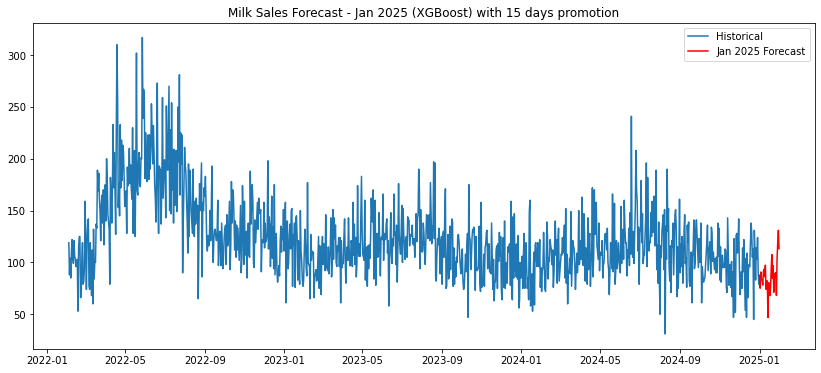

In [233]:
plt.figure(figsize=(14,6))

plt.plot(df_ml_final.index, df_ml_final['units_sold'], label='Historical')
plt.plot(forecast_jan25_15.index, forecast_jan25_15, color='red', label='Jan 2025 Forecast')

plt.legend()
plt.title("Milk Sales Forecast - Jan 2025 (XGBoost) with 15 days promotion")
plt.show()

In [234]:
residuals=y_test_ml-y_pred_ml
residuals

date
2024-06-02    26.220886
2024-06-03    -7.006317
2024-06-04     5.282120
2024-06-05    30.994904
2024-06-06    -4.457748
                ...    
2024-12-27    -9.655258
2024-12-28    13.367203
2024-12-29   -10.949097
2024-12-30   -36.765015
2024-12-31    -2.031311
Name: units_sold, Length: 213, dtype: float64

In [235]:
res_std = np.std(residuals)

In [236]:
res_std 

15.83709957182997

In [238]:
lower_bound = forecast_jan25_15 - 1.96 * res_std
upper_bound = forecast_jan25_15 + 1.96 * res_std


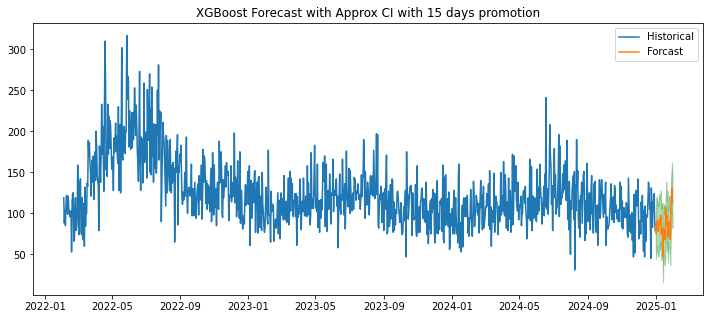

In [240]:
plt.figure(figsize=(12,5))
plt.plot(df_ml_final.index,df_ml_final['units_sold'],label='Historical')
plt.plot(forecast_jan25_15.index,forecast_jan25_15,label='Forcast')


plt.fill_between(
    forecast_jan25_15.index,
    lower_bound,
    upper_bound,
    color='green',
    alpha=0.3
)

plt.title("XGBoost Forecast with Approx CI with 15 days promotion")
plt.legend()
plt.show()

In [241]:
df_fut_2=pd.read_excel(r"C:\Users\mohit\OneDrive\Desktop\31_day.xlsx")
df_fut_2

,date,promotion_flag,stock,delivery_days,price
0,2025-01-01,1,900,2,4.053191
1,2025-01-02,1,950,3,4.924404
2,2025-01-03,1,1000,2,6.225606
3,2025-01-04,1,980,3,4.606989
4,2025-01-05,1,990,3,5.331429
5,2025-01-06,1,1050,4,4.358229
6,2025-01-07,1,1200,3,5.622759
7,2025-01-08,1,1300,2,4.348478
8,2025-01-09,1,1100,2,4.281240
9,2025-01-10,1,1400,3,4.693714


In [242]:
df_fut_2['date']=pd.to_datetime(df_fut_2['date'])
df_fut_2.set_index('date',inplace=True)
df_fut_2=df_fut_2.sort_index()

In [218]:
df_fut_2

,promotion_flag,stock,delivery_days,price
date,,,,
2025-01-01,1,900,2,4.053191
2025-01-02,1,950,3,4.924404
2025-01-03,1,1000,2,6.225606
2025-01-04,1,980,3,4.606989
2025-01-05,1,990,3,5.331429
2025-01-06,1,1050,4,4.358229
2025-01-07,1,1200,3,5.622759
2025-01-08,1,1300,2,4.348478
2025-01-09,1,1100,2,4.281240


In [243]:
df_temp_2= df_ml_final.copy()

predictions_2 = []

feature_order = model_xgb_3.feature_names_in_

for i in range(31):

    # ----- CREATE LAG FEATURES -----
    lag_1 = df_temp_2['units_sold'].iloc[-1]
    lag_7 = df_temp_2['units_sold'].iloc[-7]
    lag_14 = df_temp_2['units_sold'].iloc[-14]

    roll_mean_7 = df_temp_2['units_sold'].iloc[-7:].mean()
    roll_std_7 = df_temp_2['units_sold'].iloc[-7:].std()

    # ----- FUTURE EXOG VALUES -----
    promotion_flag= df_fut_2.iloc[i]['promotion_flag']
    stock = df_fut_2.iloc[i]['stock']
    delivery_days = df_fut_2.iloc[i]['delivery_days']
    price = df_fut_2.iloc[i]['price']

    # ----- BUILD NEW ROW -----
    X_new_2= pd.DataFrame([{
        'lag_1': lag_1,
        'lag_7': lag_7,
        'lag_14': lag_14,
        'rol_mean_7': roll_mean_7,
        'rol_std_7': roll_std_7,
        'promotion_flag': promotion_flag,
        'stock': stock,
        'delivery_days': delivery_days,
        'price': price
    }])

    #  Fix column order
    X_new_2 = X_new_2.reindex(columns=feature_order)

    # ----- PREDICT -----
    y_pred_2 = model_xgb_3.predict(X_new_2)[0]

    predictions_2.append(y_pred_2)

    # ----- APPEND PREDICTION BACK -----
    new_row_2 = df_fut_2.iloc[i:i+1].copy()
    new_row_2['units_sold'] = y_pred_2

    df_temp_2= pd.concat([df_temp_2, new_row_2])

# Convert to series with date index
forecast_jan25_31 = pd.Series(predictions_2, index=df_fut_2.index)

print(forecast_jan25_31.head(31))

date
2025-01-01     87.582581
2025-01-02     85.184013
2025-01-03     88.984665
2025-01-04     83.020851
2025-01-05     83.078651
2025-01-06     90.301178
2025-01-07    104.035240
2025-01-08    104.025017
2025-01-09     96.517792
2025-01-10    109.754700
2025-01-11     73.412842
2025-01-12     83.993790
2025-01-13     82.127777
2025-01-14     60.958363
2025-01-15     80.219429
2025-01-16     83.521294
2025-01-17     84.329651
2025-01-18     84.322609
2025-01-19    103.056244
2025-01-20    105.627510
2025-01-21     94.515358
2025-01-22     97.741516
2025-01-23     67.965317
2025-01-24     85.269707
2025-01-25     88.344574
2025-01-26    100.684044
2025-01-27     80.610092
2025-01-28    109.963303
2025-01-29    119.613037
2025-01-30    136.047348
2025-01-31    136.012543
dtype: float32


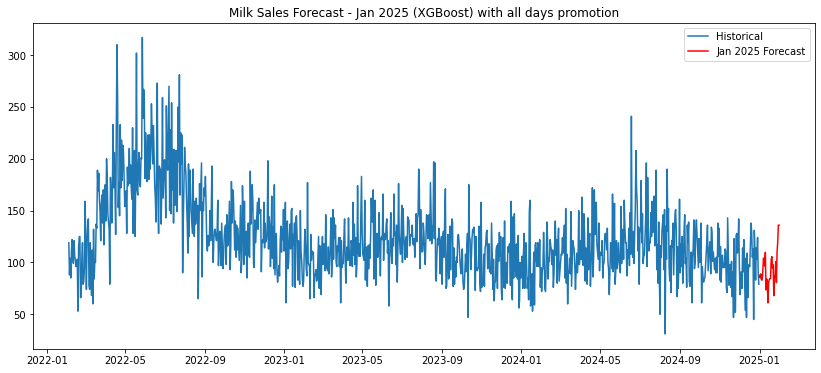

In [244]:
plt.figure(figsize=(14,6))

plt.plot(df_ml_final.index, df_ml_final['units_sold'], label='Historical')
plt.plot(forecast_jan25_31.index, forecast_jan25_31, color='red', label='Jan 2025 Forecast')

plt.legend()
plt.title("Milk Sales Forecast - Jan 2025 (XGBoost) with all days promotion")
plt.show()

In [246]:
lower_bound_1= forecast_jan25_31 - 1.96 * res_std
upper_bound_1= forecast_jan25_31 + 1.96 * res_std


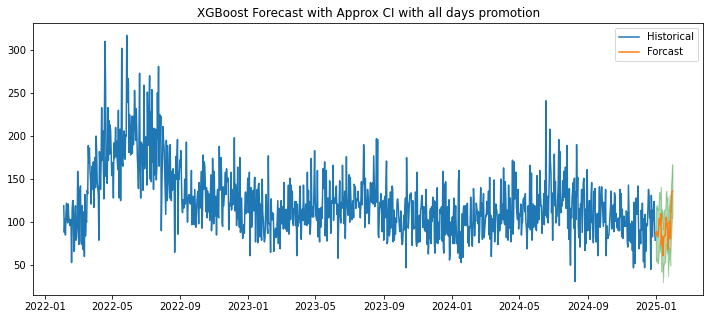

In [248]:
plt.figure(figsize=(12,5))
plt.plot(df_ml_final.index,df_ml_final['units_sold'],label='Historical')
plt.plot(forecast_jan25_31.index,forecast_jan25_31,label='Forcast')


plt.fill_between(
    forecast_jan25_31.index,
    lower_bound_1,
    upper_bound_1,
    color='green',
    alpha=0.3
)

plt.title("XGBoost Forecast with Approx CI with all days promotion")
plt.legend()
plt.show()

In [249]:
df_fut_3=pd.read_excel(r"C:\Users\mohit\OneDrive\Desktop\No_promo.xlsx")
df_fut_3

,date,promotion_flag,stock,delivery_days,price
0,2025-01-01,0,900,2,4.053191
1,2025-01-02,0,950,3,4.924404
2,2025-01-03,0,1000,2,6.225606
3,2025-01-04,0,980,3,4.606989
4,2025-01-05,0,990,3,5.331429
5,2025-01-06,0,1050,4,4.358229
6,2025-01-07,0,1200,3,5.622759
7,2025-01-08,0,1300,2,4.348478
8,2025-01-09,0,1100,2,4.281240
9,2025-01-10,0,1400,3,4.693714


In [250]:
df_fut_3['date']=pd.to_datetime(df_fut_3['date'])
df_fut_3.set_index('date',inplace=True)
df_fut_3=df_fut_3.sort_index()

In [251]:
df_fut_3.head()

,promotion_flag,stock,delivery_days,price
date,,,,
2025-01-01,0,900,2,4.053191
2025-01-02,0,950,3,4.924404
2025-01-03,0,1000,2,6.225606
2025-01-04,0,980,3,4.606989
2025-01-05,0,990,3,5.331429


In [252]:
df_temp_3= df_ml_final.copy()

predictions_3 = []

feature_order = model_xgb_3.feature_names_in_

for i in range(31):

    # ----- CREATE LAG FEATURES -----
    lag_1 = df_temp_3['units_sold'].iloc[-1]
    lag_7 = df_temp_3['units_sold'].iloc[-7]
    lag_14 = df_temp_3['units_sold'].iloc[-14]

    roll_mean_7 = df_temp_3['units_sold'].iloc[-7:].mean()
    roll_std_7 = df_temp_3['units_sold'].iloc[-7:].std()

    # ----- FUTURE EXOG VALUES -----
    promotion_flag= df_fut_3.iloc[i]['promotion_flag']
    stock = df_fut_3.iloc[i]['stock']
    delivery_days = df_fut_3.iloc[i]['delivery_days']
    price = df_fut_3.iloc[i]['price']

    # ----- BUILD NEW ROW -----
    X_new_3= pd.DataFrame([{
        'lag_1': lag_1,
        'lag_7': lag_7,
        'lag_14': lag_14,
        'rol_mean_7': roll_mean_7,
        'rol_std_7': roll_std_7,
        'promotion_flag': promotion_flag,
        'stock': stock,
        'delivery_days': delivery_days,
        'price': price
    }])

    #  Fix column order
    X_new_3 = X_new_3.reindex(columns=feature_order)

    # ----- PREDICT -----
    y_pred_3 = model_xgb_3.predict(X_new_3)[0]

    predictions_3.append(y_pred_3)

    # ----- APPEND PREDICTION BACK -----
    new_row_3 = df_fut_3.iloc[i:i+1].copy()
    new_row_3['units_sold'] = y_pred_3

    df_temp_3= pd.concat([df_temp_3, new_row_3])

# Convert to series with date index
forecast_jan25_0 = pd.Series(predictions_3, index=df_fut_3.index)

print(forecast_jan25_0.head(31))

date
2025-01-01     74.569565
2025-01-02     75.002052
2025-01-03     77.333168
2025-01-04     69.223961
2025-01-05     71.201782
2025-01-06     76.654083
2025-01-07     91.681122
2025-01-08     94.900253
2025-01-09     86.648544
2025-01-10     98.997017
2025-01-11     69.764885
2025-01-12     74.918671
2025-01-13     71.492676
2025-01-14     47.901283
2025-01-15     67.326866
2025-01-16     70.959747
2025-01-17     68.542900
2025-01-18     75.474274
2025-01-19     92.899460
2025-01-20     99.151024
2025-01-21     71.877159
2025-01-22     87.537064
2025-01-23     64.919495
2025-01-24     82.242226
2025-01-25     77.454224
2025-01-26     86.486359
2025-01-27     68.680450
2025-01-28    104.577713
2025-01-29    107.493324
2025-01-30    110.757988
2025-01-31    110.985046
dtype: float32


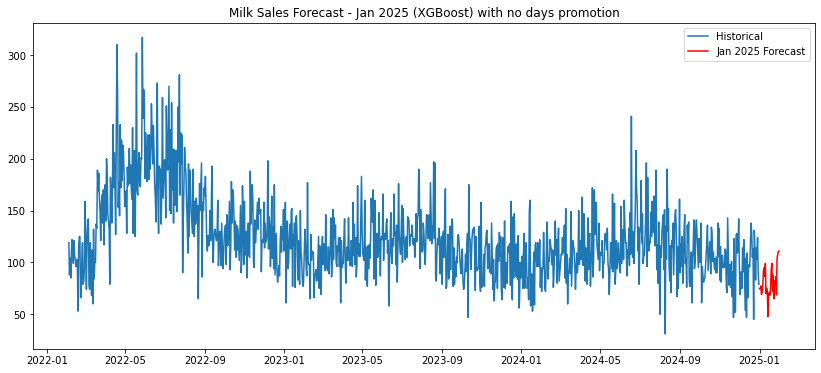

In [253]:
plt.figure(figsize=(14,6))

plt.plot(df_ml_final.index, df_ml_final['units_sold'], label='Historical')
plt.plot(forecast_jan25_0.index, forecast_jan25_0, color='red', label='Jan 2025 Forecast')

plt.legend()
plt.title("Milk Sales Forecast - Jan 2025 (XGBoost) with no days promotion")
plt.show()

In [254]:
lower_bound_2= forecast_jan25_0 - 1.96 * res_std
upper_bound_2= forecast_jan25_0 + 1.96 * res_std


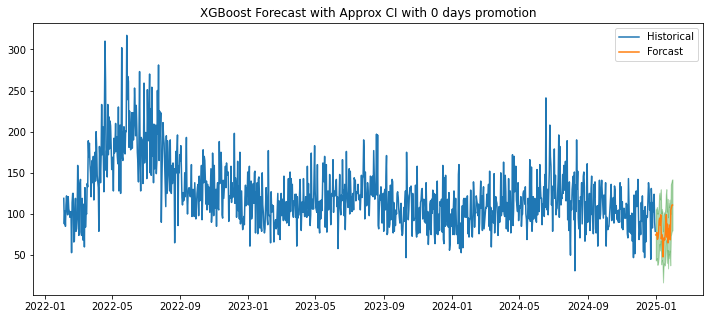

In [255]:
plt.figure(figsize=(12,5))
plt.plot(df_ml_final.index,df_ml_final['units_sold'],label='Historical')
plt.plot(forecast_jan25_0.index,forecast_jan25_0,label='Forcast')


plt.fill_between(
    forecast_jan25_0.index,
    lower_bound_2,
    upper_bound_2,
    color='green',
    alpha=0.3
)

plt.title("XGBoost Forecast with Approx CI with 0 days promotion")
plt.legend()
plt.show()

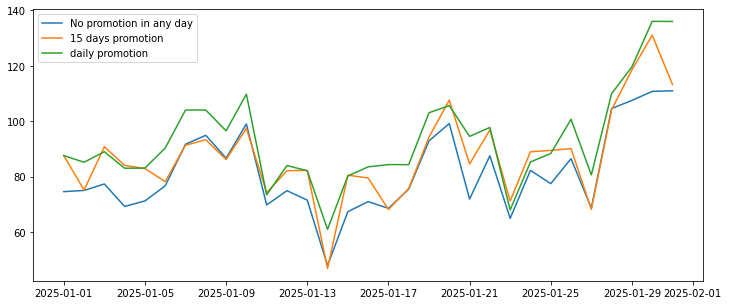

In [258]:
plt.figure(figsize=(12,5))

plt.plot(forecast_jan25_0.index,forecast_jan25_0,label='No promotion in any day')
plt.plot(forecast_jan25_15.index,forecast_jan25_15,label='15 days promotion')
plt.plot(forecast_jan25_31.index,forecast_jan25_31,label='daily promotion')
plt.legend()
plt.show()

In [260]:
print('sales with 0 day promo',forecast_jan25_0.sum())
print('sales with 15 days promo',forecast_jan25_15.sum())
print('sales with all day promo',forecast_jan25_31.sum())


sales with 0 day promo 2527.6545
sales with 15 days promo 2714.1343
sales with all day promo 2890.8208


**Incremental Lift Analysis**

To evaluate the business impact of promotions, three scenarios were simulated for January 2025:

No promotion (0 days)

Partial promotion (15 days)

Full month promotion (31 days)

Scenario	Total Forecasted Sales
0 days promo	2527 units
15 days promo	2714 units
31 days promo	2890 units


Incremental Impact

**15-day promotion vs No promotion:
+187 units (+7.4% uplift)**

**Full month promotion vs No promotion:
+363 units (+14.3% uplift)**

The model captures the positive elasticity of demand with respect to promotional activity. Sales increase consistently as the number of promotion days increases, indicating that the model is sensitive to promotional signals and produces economically meaningful forecasts.

This demonstrates the model’s capability to support promotional planning and revenue optimization decisions.

**8. Rolling Validation**

In [263]:

# store results
results = []

# select 2024 months
months = pd.date_range("2024-01-01", "2024-12-01", freq="MS")


for month_start in months:

    month_end = month_start + pd.offsets.MonthEnd(0)

    # Train data = everything before month
    train_data = df_ml_final[df_ml_final.index < month_start]

    # Test data = that month
    test_data = df_ml_final[
        (df_ml_final.index >= month_start) &
        (df_ml_final.index <= month_end)
    ]

    X_train_r= train_data.drop("units_sold", axis=1)
    y_train_r = train_data["units_sold"]

    X_test_r = test_data.drop("units_sold", axis=1)
    y_test_r= test_data["units_sold"]

    # Train model
    model_r = XGBRegressor(
        n_estimators=300,
        learning_rate=0.05,
        max_depth=5,
        random_state=42
    )

    model_r.fit(X_train_r, y_train_r)

    # Predict
    y_pred_r = model_r.predict(X_test_r)

    # Errors
    mae_r = mean_absolute_error(y_test_r, y_pred_r)
    rmse_r = np.sqrt(mean_squared_error(y_test_r, y_pred_r))
    mape_r = mean_absolute_percentage_error(y_test_r,y_pred_r) * 100

    results.append({
        "Month": month_start.strftime("%Y-%m"),
        "MAE_r": mae_r,
        "RMSE_r": rmse_r,
        "MAPE_r": mape_r
    })

In [264]:
results_df = pd.DataFrame(results)
results_df


,Month,MAE_r,RMSE_r,MAPE_r
0,2024-01,13.754365,16.940142,14.384177
1,2024-02,10.513225,13.750106,10.374758
2,2024-03,11.824227,14.218620,11.558720
3,2024-04,11.999958,14.817030,10.137578
4,2024-05,9.179035,11.548990,8.282757
5,2024-06,16.063086,22.008029,11.788348
6,2024-07,11.882624,17.152364,8.774944
7,2024-08,13.710730,17.248521,14.835654
8,2024-09,8.829016,10.736521,8.213207
9,2024-10,9.881580,12.302727,10.059775


In [266]:
results_df[['MAE_r','RMSE_r','MAPE_r']].mean()


MAE_r     11.569378
RMSE_r    14.716563
MAPE_r    11.108087
dtype: float64

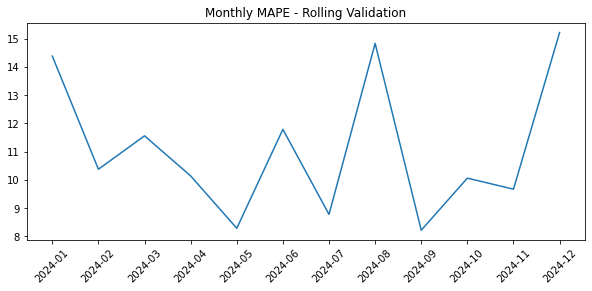

In [267]:
plt.figure(figsize=(10,4))
plt.plot(results_df['Month'], results_df['MAPE_r'])
plt.xticks(rotation=45)
plt.title("Monthly MAPE - Rolling Validation")
plt.show()


To evaluate real-world robustness, we implemented expanding window rolling validation.

Instead of performing a single train-test split, the model was retrained using all available historical data up to that point and evaluated on the following month.

This simulates real business deployment where models are continuously updated as new data becomes available.

Results:

Average MAE ≈ 11.56 units

Average RMSE ≈ 14.71 units

Average MAPE ≈ ~11.10%

Interpretation:

Error remains stable across months

No severe performance degradation

Model generalizes well to unseen periods

This confirms that the model is production-ready and stable over time.

**9.Conclusion**

**1.Model Comparison Summary**

Model	MAE	RMSE MAPE

ARIMA	~22	~30	~23%
SARIMAX	~15	~19	~14%
XGBoost	~11	~15	~11%

**Interpretation:**

**ARIMA** performs worst (univariate limitation)

**SARIMAX** improves by including external factors

**XGBoost** delivers best performance due to:

Non-linearity capture

Interaction learning

Automatic feature weighting

Hence, **XGBoost is selected as final production model**





**2. Promotion Scenario Analysis (Business Simulation)**

We simulated three scenarios for January 2025:

Scenario	  Total Predicted Sales
0 Promo Days	2527
15 Promo Days	2714
31 Promo Days	2891

**Insights:**

Moving from 0 to 15 promo days increases sales significantly.

Full-month promotion increases sales further

Promotion has measurable positive impact on demand.

**Business Interpretation:**

Promotions drive demand uplift, but continuous promotion may not proportionally increase sales and could impact margin.

Optimal strategy may involve targeted promotional windows instead of full-month campaigns.

**3.Key Drivers Identified:**

    7-day rolling mean (recent demand trend)

    Stock availability

    Promotion flag

    Lag features (recent historical sales)

**Interpretation:**

    Recent demand behavior is strongest predictor

    Stock availability significantly impacts sales

    Promotion has positive influence

    Delivery & price have moderate influence

    This aligns with business logic.

**Final Conclusion**

This study aimed to forecast daily milk sales using time-series and machine learning approaches.

Key Findings:

    The sales series exhibits significant trend but no strong seasonality.

    ARIMA (univariate) is insufficient for accurate forecasting.

    Including external variables via SARIMAX improves performance.

    Machine learning (XGBoost) delivers highest accuracy.

    Promotion planning significantly affects demand.

    Model performance is stable under rolling validation.

    Overall, the XGBoost model with engineered lag features provides the most reliable forecasting framework.


**10. Business Recommendations**

1. Use XGBoost model for operational demand forecasting.

2. Plan promotions strategically — full-month promotions increase volume but may reduce profitability.

3. Maintain adequate stock levels — stock availability strongly influences sales realization.

4. Update model monthly using rolling retraining.

5. Use forecast confidence intervals for inventory planning buffer decisions.

**11. Limitations**

Data limited to historical internal variables only.

No external macroeconomic variables included such as competitor pricing.

Assumes stable demand pattern.

Scenario simulation assumes static external factors except promotion.

Model performance depends on quality of future exogenous inputs.
